c:\Users\miralles\AppData\Local\miniconda3\envs\qf\Lib\site-packages\arch\univariate\recursions_python.py:14: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.2)
  from scipy.special import gammaln
[*********************100%***********************]  1 of 1 completed


Ticker            ^IXIC
Date                   
2019-01-02  6665.939941
2019-01-03  6463.500000
2019-01-04  6738.859863
2019-01-07  6823.470215
2019-01-08  6897.000000
ARCH Test:
LM stat: 464.2533073251486, p-value: 1.9005526622030144e-93


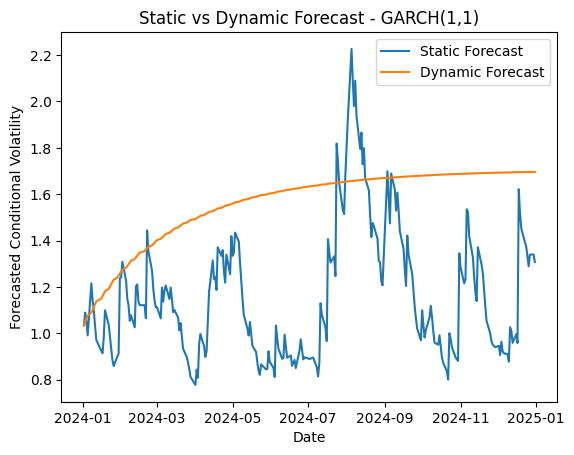

Ticker         ^IXIC
Date                
2024-01-03  0.328661
2024-01-04  0.438851
2024-01-05  0.465111
2024-01-08  1.472504
2024-01-09  1.473202
Static RMSE: 0.6841
Dynamic RMSE: 0.9935


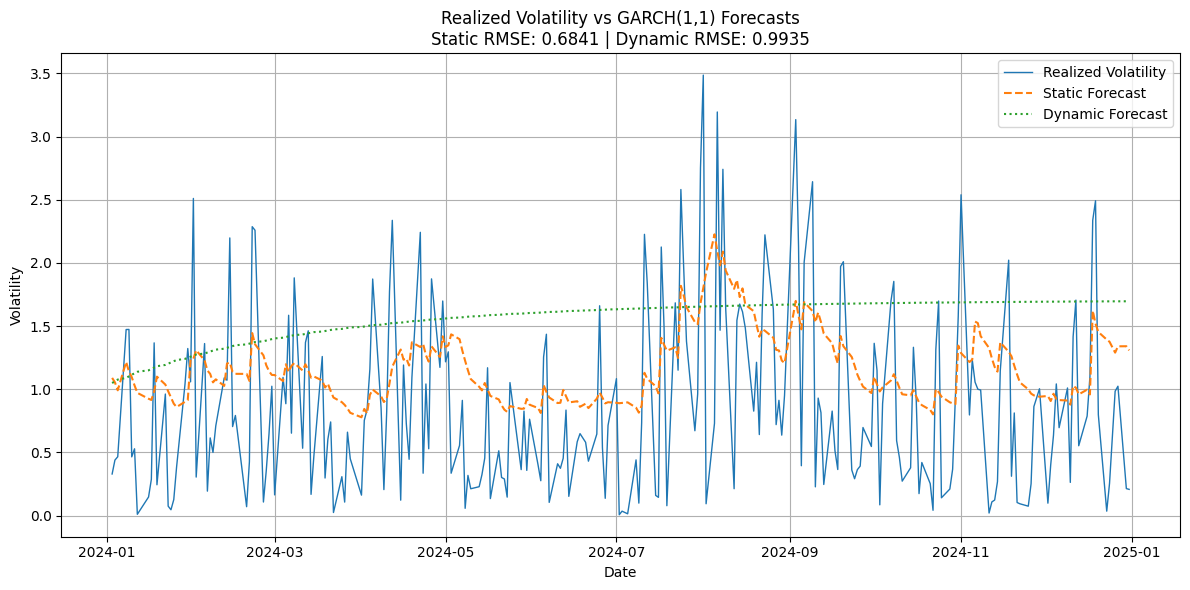

In [ ]:
'''
Import the necessary libraries for financial volatility analysis.
'''

import yfinance as yf
import pandas as pd
import numpy as np
from arch import arch_model
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_arch
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

'''
Download adjusted closing prices of NASDAQ (^IXIC) for the period 2019–2025,
remove missing values, and display the first rows.
'''

ticker = "^IXIC"
data = yf.download(ticker, start="2019-01-01", end="2025-01-01", auto_adjust=True)
data = data['Close']
data = data.dropna()
data.name = 'Close'
print(data.head())

'''
Compute daily logarithmic returns in percentage.
'''

returns = 100 * (np.log(data) - np.log(data.shift(1)))
returns = returns.dropna()
returns.name = "Log Returns"

'''
Fit a simple linear regression model
and apply the ARCH effects test on the residuals.
'''

returns_const = sm.add_constant(returns)
ols_model = sm.OLS(returns, returns_const['const']).fit()
arch_test = het_arch(ols_model.resid)

print("ARCH Test:")
print(f"LM stat: {arch_test[0]}, p-value: {arch_test[1]}")

'''
Split the series into two periods: the first 5 years for estimation (train)
and the last year for forecasting (test).
'''

train = returns[:'2023-12-31']
test = returns['2024-01-01':]

'''
Estimate static volatility forecasts with a GARCH(1,1) model,
fitting the model up to each date in the out-of-sample period.
'''

am = arch_model(returns, vol='GARCH', p=1, q=1)

cvar_stat = {}
for date in test.index:
    res = am.fit(last_obs=date, disp='off')
    forecast = res.forecast(horizon=1)
    cvar_stat[date] = forecast.variance.iloc[1, 0]  # Forecasted variance for h=1

# Convert variances to volatilities (standard deviation)
static_vol = pd.Series(np.sqrt(list(cvar_stat.values())), index=list(cvar_stat.keys()), name="Static Volatility")

'''
Generate dynamic volatility forecasts with a GARCH(1,1) model,
fitted once with data up to the beginning of 2024.
'''

am = arch_model(returns, vol='GARCH', p=1, q=1)
res = am.fit(last_obs=test.index[0], disp='off')
forecast = res.forecast(horizon=len(test))
forecast_var = forecast.variance.dropna()
dynamic_vol_df = pd.DataFrame(
    data=np.sqrt(forecast_var.iloc[1].values),
    columns=['Dynamic Volatility'],
    index=test.index
)

'''
Plot the forecasted volatility under the static and dynamic approaches
for the out-of-sample period (2024).
'''

plt.figure(1)

# Static forecast series
plt.plot(static_vol, label='Static Forecast')

# Dynamic forecast series
plt.plot(dynamic_vol_df, label='Dynamic Forecast')

plt.xlabel('Date')
plt.ylabel('Forecasted Conditional Volatility')
plt.title('Static vs Dynamic Forecast - GARCH(1,1)')
plt.legend()
plt.show()

'''
Compute realized volatility as the 2-day rolling standard deviation
of out-of-sample returns (2024).
'''

realized_vol = test.rolling(window=2).std().dropna()
realized_vol.name = 'Realized Volatility'
print(realized_vol.head())

'''
Extract the dynamic forecast series and compute the RMSE of both approaches
by comparing against realized volatility.
'''

# Extract column as Series from DataFrame
dynamic_vol = dynamic_vol_df.iloc[:, 0]

# Compute RMSE between realized volatility and forecasts
rmse_static = np.sqrt(mean_squared_error(realized_vol, static_vol.loc[realized_vol.index]))
rmse_dynamic = np.sqrt(mean_squared_error(realized_vol, dynamic_vol.loc[realized_vol.index]))

print(f"Static RMSE: {rmse_static:.4f}")
print(f"Dynamic RMSE: {rmse_dynamic:.4f}")

'''
Compare realized volatility with static and dynamic forecasts graphically.
'''

# Align common dates among the three series
common_index = realized_vol.index.intersection(static_vol.index).intersection(dynamic_vol.index)

# Ensure realized_vol is also a 1D Series
realized_vol = realized_vol.squeeze()

# Create combined DataFrame
df_vol = pd.DataFrame({
    'Realized': realized_vol.loc[common_index],
    'Static': static_vol.loc[common_index],
    'Dynamic': dynamic_vol.loc[common_index]
})

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_vol['Realized'], label='Realized Volatility', linewidth=1)
plt.plot(df_vol['Static'], label='Static Forecast', linestyle='--')
plt.plot(df_vol['Dynamic'], label='Dynamic Forecast', linestyle=':')
plt.title(f'Realized Volatility vs GARCH(1,1) Forecasts\nStatic RMSE: {rmse_static:.4f} | Dynamic RMSE: {rmse_dynamic:.4f}')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

 ## Volatility Model Performance Analysis
 
 The GARCH(1,1) model applied to the NASDAQ index shows good performance in capturing the heteroskedastic nature of financial returns. The presence of ARCH effects was statistically confirmed, justifying the use of this type of model.
 
 Two forecasting approaches were implemented:
 
 - **Static forecast:** the model is recalibrated at each date of the out-of-sample period. This approach achieved a lower RMSE, indicating greater accuracy in tracking daily fluctuations of realized volatility.
 
 - **Dynamic forecast:** the model is fitted once before the evaluation period and projected forward. This method is computationally more efficient but showed less adaptability to sudden changes, reflected in a higher RMSE.
 
 **Conclusion:** Although both approaches are valid, the static forecast proves more accurate during periods of high variability, as it better adapts to market changes.
